In [20]:
from datetime import datetime as dt
from preprocessing import Preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, RocCurveDisplay
from imblearn.over_sampling import RandomOverSampler

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")
    

tensor([1.], device='mps:0')


In [22]:
def plot_history(history, metric='accuracy'):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    
    plt.plot(history.history['loss'], 'b', label='Training loss')
    plt.plot(history.history['val_loss'], 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history[metric], 'b', label='Training accuracy')
    plt.plot(history.history[f'val_{metric}'],'r', label='Validation accuracy')
    plt.title('Training and validation auc')
    plt.legend()

# Preprocessing

In [23]:
col_drop = ['CustomerId','Surname']
types = {
    'HasCrCard':bool,
    'IsActiveMember':bool
}
train = pd.read_csv('data/train.csv', index_col='id', dtype=types).drop(columns=col_drop)
test = pd.read_csv('data/test.csv', index_col='id', dtype=types).drop(columns=col_drop)

In [24]:
train.shape

(165034, 11)

In [25]:
X = train.drop(columns='Exited')
y = train.Exited

In [26]:
y.value_counts(True)

Exited
0    0.788401
1    0.211599
Name: proportion, dtype: float64

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X,y,stratify=y)

In [28]:
y_train.shape

(123775,)

In [29]:
y_train.value_counts(True)

Exited
0    0.788398
1    0.211602
Name: proportion, dtype: float64

In [30]:
ros = RandomOverSampler(random_state=42)
#X_train, y_train = ros.fit_resample(X_train, y_train)

In [31]:
y_train.shape

(123775,)

In [32]:
y_train.value_counts(True)

Exited
0    0.788398
1    0.211602
Name: proportion, dtype: float64

In [33]:
prepro = Preprocessing()

In [34]:
dict_type = {
    'Geography': 'float64',
    'Gender': 'float64',
    'HasCrCard': 'float64',
    'IsActiveMember': 'float64',
    }

In [35]:
X_train_scld = prepro.fit_transform(X_train).astype(dict_type).values
X_val_scld = prepro.transform(X_val).astype(dict_type).values

In [62]:
train_dataset = TensorDataset(torch.tensor(X_train_scld, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.int64))
val_dataset = TensorDataset(torch.tensor(X_val_scld, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.int64))

BatchSize = 64
train_loader = DataLoader(train_dataset, batch_size=BatchSize, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BatchSize, shuffle=True)

# Model

In [72]:
class Model(nn.Module):
    def __init__(self, hidden_size1, hidden_size2):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(10, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [73]:
# Fonction de perte pondérée pour classes déséquilibrées
def weighted_binary_cross_entropy(output, target, weights=None):
    if weights is not None:
        assert len(weights) == 2

        loss = weights[1] * (target * torch.log(output + 1e-10)) + \
               weights[0] * ((1 - target) * torch.log(1 - output + 1e-10))
    else:
        loss = target * torch.log(output + 1e-10) + (1 - target) * torch.log(1 - output + 1e-10)

    return torch.neg(torch.mean(loss))

In [74]:
model = Model(32,16)

In [76]:
weights = y.value_counts(True).to_list()
criterion = weighted_binary_cross_entropy
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [78]:
num_epochs = 100

for epoch in range(num_epochs):
    total_loss = 0.0

    for batch_x, batch_y in train_loader:
        # Passe avant
        output = model(batch_x)

        # Calcul de la perte
        loss = criterion(output, batch_y)
        total_loss += loss.item()
        print(output,batch_y )
        # Rétropropagation et mise à jour des poids
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculer la perte moyenne pour l'époque
    average_loss = total_loss / len(train_loader)

    # Afficher la perte moyenne pour chaque époque
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

# À la fin de la boucle d'entraînement, votre modèle devrait être entraîné.


tensor([[0.2161],
        [0.2230],
        [0.2252],
        [0.1973],
        [0.2472],
        [0.2194],
        [0.2308],
        [0.2130],
        [0.2054],
        [0.2363],
        [0.2204],
        [0.2450],
        [0.2522],
        [0.2268],
        [0.2254],
        [0.2140],
        [0.1896],
        [0.2240],
        [0.2053],
        [0.1973],
        [0.2011],
        [0.2166],
        [0.2068],
        [0.2028],
        [0.2046],
        [0.2074],
        [0.2354],
        [0.2150],
        [0.1980],
        [0.1985],
        [0.2130],
        [0.2150],
        [0.2328],
        [0.2007],
        [0.1888],
        [0.2089],
        [0.2063],
        [0.2013],
        [0.2125],
        [0.2071],
        [0.2061],
        [0.2171],
        [0.1828],
        [0.2183],
        [0.2232],
        [0.2191],
        [0.2170],
        [0.2238],
        [0.2146],
        [0.2174],
        [0.2029],
        [0.2064],
        [0.2359],
        [0.2043],
        [0.2496],
        [0

KeyboardInterrupt: 

# Score

In [21]:
pred = model.predict(X_test_scld.values)

1290/1290 [==============================] - 2s 2ms/step


In [36]:
RocScore  = roc_auc_score(y_test, pred[:,0])
print(f'Roc Auc Score : {RocScore:.6f}')

Roc Auc Score : 0.814817


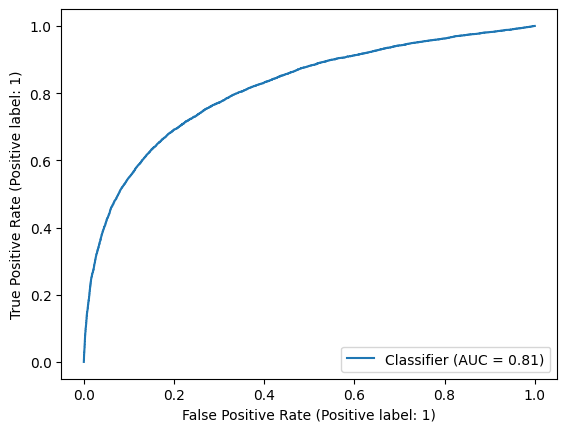

In [86]:
RocCurveDisplay.from_predictions(y_test,pred[:,0])

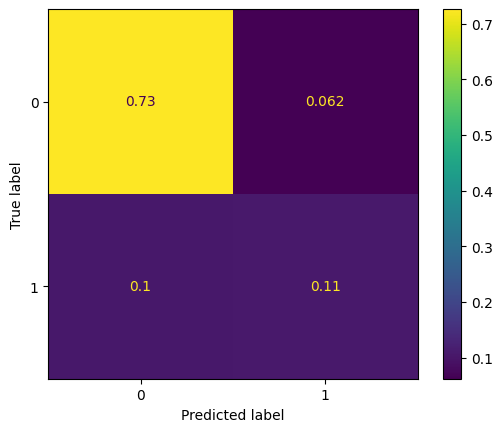

In [79]:
ConfusionMatrixDisplay(confusion_matrix(y_test,pred[:,0]>0.5, normalize='all')).plot()

# Submission

In [ ]:
X_val_scld = prepro.transform(test)

In [ ]:
submission = pd.read_csv("data/sample_submission.csv", index_col='id')

In [ ]:
submission.loc[:,'Exited'] = nn.predict_proba(X_val_scld)[:,1]

/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [ ]:
submission

Exited
id              
165034  0.085936
165035  0.947197
165036  0.079534
165037  0.519489
165038  0.638603
...          ...
275052  0.132850
275053  0.217605
275054  0.071276
275055  0.381622
275056  0.496457

[110023 rows x 1 columns]

In [ ]:
name = dt.now().strftime("%Y%m%d_%H%M")

In [ ]:
#submission.to_csv(f"submission/{name}.csv")